# Homework 5: taming text

In [1]:
import pandas as pd
import numpy as np
from os import path
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import stem
from nltk.stem.wordnet import WordNetLemmatizer
import pycountry
import string

## Part 1: word clouds

We start by taking a look at the data

In [2]:
data = pd.read_csv("./hillary-clinton-emails/Emails.csv")
data.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


We are only interested in the content of the email, in this case the ExtractedBodyText and the ExtractedSubject.

In [3]:
data.ExtractedBodyText = data.ExtractedBodyText.fillna('')
data.ExtractedSubject = data.ExtractedSubject.fillna('')
mails = pd.DataFrame(data.ExtractedSubject + " " + data.ExtractedBodyText)
mails.columns = ['content']
print(mails.size)
mails.head()

7945


,content
0,FW: Wow
1,"B6\nThursday, March 3, 2011 9:45 PM\nH: Lates..."
2,Re: Chris Stevens Thx
3,FVV: Cairo Condemnation - Final
4,"H <hrod17@clintonemail.com>\nFriday, March 11..."


In order to create the first word cloud we need to concatenate all the email content together.

In [4]:
content = mails.content.str.cat(sep=' ')
content[0:100]

'FW: Wow   B6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nh'

In [5]:
wordcloud = WordCloud().generate(content)

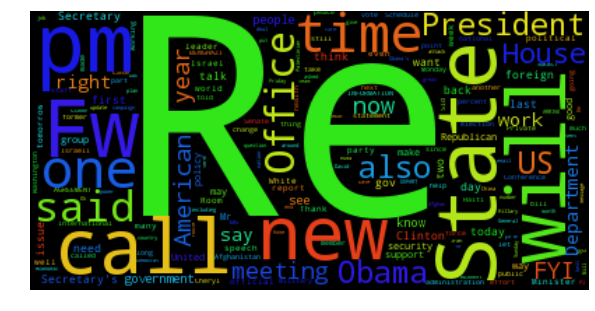

In [6]:
plt.subplots(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

We will now pre-process the text in order to remove words such as re, fw, pm, new, also, many. This way our worldcloud will contain more useful words.

### Text pre-processing

We start by **tokenizing** the text. The regex tokenizer will also remove ponctuation.

In [7]:
# nltk.download() # run this if lookup error english.pickle
pattern = r'''(?x)          # set flag to allow verbose regexps
        (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
      | \w+(?:-\w+)*        # words with optional internal hyphens
      | \$?\d+(?:\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
      | \.\.\.              # ellipsis
      | [][.,;"'?():_`-]    # these are separate tokens; includes ], [
    '''
tokenizer = RegexpTokenizer(pattern)
tokens = tokenizer.tokenize(content)
tokens[0:10]

['FW', ':', 'Wow', 'B6', 'Thursday', ',', 'March', '3', ',', '2011']

We transform the tokens to all lowercase.

In [16]:
tokens = [x.lower() for x in tokens if x not in ['US', 'U.S.']]
tokens[0:10]

['fw', ':', 'wow', 'b6', 'thursday', ',', 'march', '3', ',', '2011']

In [17]:
len(tokens)

760650

Next we **remove stopwords**.

In [18]:
stop = stopwords.words('english') + ['re', 'fw', 'pm', 'am', 'com'] + list(string.punctuation)
tokens = [word for word in tokens if word not in stop]
tokens[0:10]

['wow', 'b6', 'thursday', 'march', '3', '2011', '9', '45', 'h', 'latest']

In [19]:
len(tokens)

376034

Next we apply **stemming**.

In [20]:
sno = stem.SnowballStemmer('english')
stemming = [sno.stem(x) for x in tokens]
stemming[0:10]

['wow', 'b6', 'thursday', 'march', '3', '2011', '9', '45', 'h', 'latest']

In [21]:
content = ' '.join(stemming)
content[0:100]

'wow b6 thursday march 3 2011 9 45 h latest syria aid qaddafi ... sid hrc memo syria aid libya 030311'

In [14]:
wordcloud = WordCloud().generate(content)

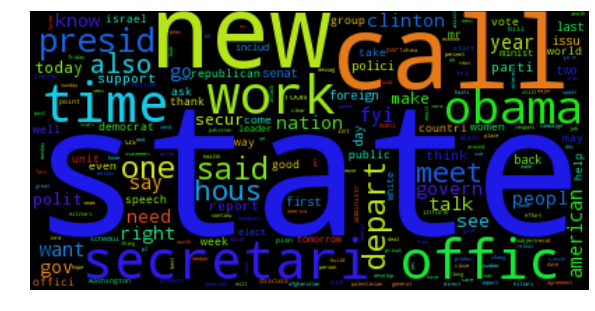

In [15]:
plt.subplots(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

This word cloud contains stems instead of actual words (e.g. offic, secratari). We now try a **lemmatizer** instead of the stemmer.

In [16]:
lmtzr = WordNetLemmatizer()
lemmas = [lmtzr.lemmatize(x) for x in tokens]
lemmas[0:10]

['wow', 'b6', 'thursday', 'march', '3', '2011', '9', '45', 'h', 'latest']

In [17]:
content = ' '.join(lemmas)
content[0:100]

'wow b6 thursday march 3 2011 9 45 h latest syria aiding qaddafi ... sid hrc memo syria aiding libya '

In [18]:
wordcloud = WordCloud().generate(content)

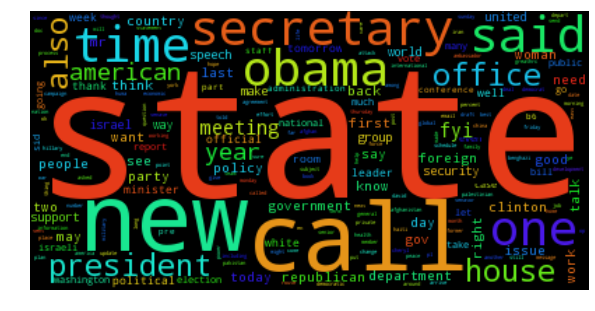

In [19]:
plt.subplots(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

We conclude that the last wordcloud is the most interesting one because the text pre-processing removed some words that didn't bring any information. And it also grouped different uses of the same word as one.

## Part 2: Sentiment analysis for countries

Let's take a look at the countries that are provided with the pycountry library.

In [8]:
pycountry.countries.get(alpha_2='SY')

Country(alpha_2='SY', alpha_3='SYR', name='Syrian Arab Republic', numeric='760')

We can see that this library will not do all the work for us. We need to figure out a way to go from 'Syrian Arab Republic' to 'Syria'. The same goes for 'Iran', 'Korea', 'Macedonia', 'Korea' and 'Tanzania'.

In [9]:
pycountry.countries.get(alpha_2='PM')

Country(alpha_2='PM', alpha_3='SPM', name='Saint Pierre and Miquelon', numeric='666')

We also need to be carefull with the use of the acronyms such as 'PM', 'AM', 'COM'. United kingdom should also be 'UK'.

We decide to make some changes to the provided library:
- 'Syrian Arab Republic' is changed to 'Syria'.
- whenever a country name contains a ',' with drop everything after ','
- We add UK as an acronym for United Kingdom

In [12]:
countries = list(pycountry.countries)
for country in countries:
    if 'Syria' in country.name:
        country.name = 'Syria'
    if ',' in country.name:
        country.name = country.name.split(',', 1)[0]
    if country.alpha_3 == 'GBR':
        country.alpha_3 = 'UK'

We define a function that for each email content will match the content to the countries that are mentioned in the email. We add acronyms to the stopwords because this list will otherwise be identified with a country.

In [70]:
# sets are much faster for operation `in`
custom_stop  = set(stopwords.words('english'))

# add useless things from email and things which collide with country short codes
custom_stop |= set(['re', 'fw', 'pm', 'am', 'com', 'fm', 'om', 'mr', 'ms', 'st', 'ben', 'cc', 'tv', 'guy'])

# add tokens made entirely of punctuation
custom_stop |= set(string.punctuation)

# add special case for US, since we don't want to mistake it for `us`
custom_stop |= set(['us'])

def lookup_countries(content):
    # transform content into tokens; this will be used to check country code (UK, USA etc)
    content_tok = tokenizer.tokenize(content)
    # reduce abbreviations: U.S.A -> USA
    for i in range(len(content_tok)):
        if '.' in content_tok[i]:
            content_tok[i] = ''.join(ch for ch in content_tok[i] if ch != '.')

    # be very careful about US; relies on lazy evaluation
    content_tok = [word.upper() for word in content_tok if word == 'US' or word.lower() not in custom_stop]

    # check if tokens correspond to countries
    present_countries = set()
    for country in countries:
        if   country.alpha_2 in content_tok \
          or country.alpha_3 in content_tok \
          or country.name.lower() in content.lower():
            present_countries.add(country.name)
    if len(present_countries) > 0:
        return set(present_countries)
    return None  # no country found

In [73]:
lookup_countries('hello U.S.A., I am from Belgium.')

{'Belgium', 'United States'}

In [74]:
lookup_countries("Us doesn't want that country")

In [75]:
lookup_countries("US is a country, though")

{'United States'}

In [76]:
mails['countries'] = mails['content'].apply(lookup_countries)
mails.head(10)

,content,countries
0,FW: Wow,None
1,"B6\nThursday, March 3, 2011 9:45 PM\nH: Lates...","{Libya, Syria}"
2,Re: Chris Stevens Thx,None
3,FVV: Cairo Condemnation - Final,None
4,"H <hrod17@clintonemail.com>\nFriday, March 11...","{Libya, Syria}"
5,Meet The Right Wing Extremist Behind Anti-Musl...,{United States}
6,"FW: Anti-Muslim film director in hiding, follo...","{Libya, Egypt}"
7,"H <hrod17@clintonemail.corn>\nFriday, March 1...","{Libya, Syria}"
8,FVV: Secretary's remarks FYI,None
9,"more on Libya B6\nWednesday, September 12, 201...",{Libya}


In [16]:
mails.iloc[6].content

'FW: Anti-Muslim film director in hiding, following Libya, Egypt violence '

In [77]:
sum(mails.countries.isnull())

5581

In [81]:
mails_countries = mails[mails.countries.notnull()]
sum(mails_countries.countries.isnull())

0

Let's take a look at the countries that are mentioned in the emails.

In [90]:
all_countries = []
for c in mails_countries['countries']:
    all_countries.extend(c)
all_countries[:10]

['Libya',
 'Syria',
 'Libya',
 'Syria',
 'United States',
 'Libya',
 'Egypt',
 'Libya',
 'Syria',
 'Libya']

We remove all the countries that are mentioned less than 10 times

In [132]:
appearing_countries = pd.DataFrame(all_countries).groupby(0).size().rename('counts')
print(appearing_countries.size)
appearing_countries = appearing_countries[appearing_countries > 10]
print(appearing_countries.size)

209
89


In [137]:
appearing_countries = pd.DataFrame(appearing_countries)
appearing_countries.index.name = 'CountryName'
appearing_countries

,counts
CountryName,
Afghanistan,144
Albania,72
Andorra,22
Angola,135
Argentina,23
Armenia,46
Australia,32
Azerbaijan,13
Bangladesh,12


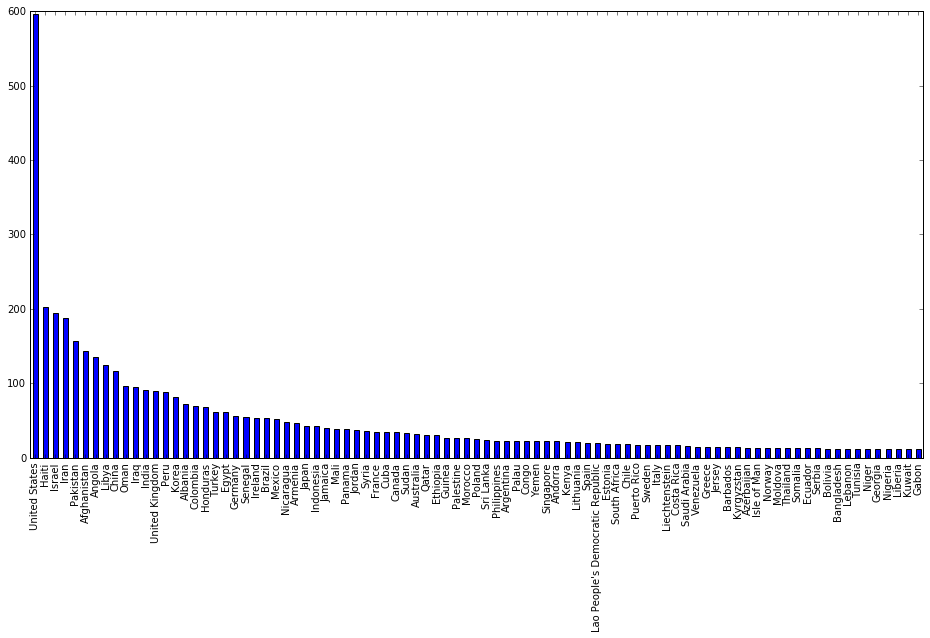

In [138]:
plt.figure(figsize=(16,8))
country_counts.plot(kind='bar')

## Sentiment analysis

We propose 2 methods for analysing the sentiment in an email.
  - vocabulary count -- simply count how many positive vs negative words are in the content
  - VADER -- see their paper

In [93]:
from nltk.corpus import opinion_lexicon
# for word in opinion_lexicon.positive():
#     print(word, end=' ')
print(opinion_lexicon.positive())

['a+', 'abound', 'abounds', 'abundance', 'abundant', ...]


    from nltk.tokenize.treebank import TreebankWordTokenizer
    from nltk.sentiment.util import mark_negation
The sneak peek above tells us that we do not need to apply stemming or lemming to use this lexicon

In [197]:
# extract these in set as the stream operation is very costly; this brings a 10x speed improvement
pos_words = set([word for word in opinion_lexicon.positive()])
neg_words = set([word for word in opinion_lexicon.negative()])

In [198]:
from nltk.tokenize.treebank import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

puncts = set(string.punctuation)
def sentiment_lexicon(email):
    """ Analyzes sentence based on simple lexicon occurence count
        Returns { -1 | 0 | 1 }
    """
        
    # some could argue that we use an expensive tokenizer which is aware of punctuation
    # just to discard it later; but in fact, we only discard words made entirely out of 
    # punctuation, since they don't exist in the lexicon anyway
    # this way, `can't` -> [ca, n't], both of which are 'neutral'. Otherwise, we would
    # have had 1 positive [`can`] and one neutral [`t`]
    tokens = [word.lower() for word in tokenizer.tokenize(email) if word not in puncts ]
        
    value = 0
    for word in tokens:
        if word in pos_words:
            value += 1
        elif word in neg_words:
            value -= 1
    
    if value == 0:
        return value
    return value / abs(value)

In [95]:
def sentiment_vader(email):
    """ Simple wrapper around VADER sentiment tool.
        Returns float [-1, 1]
    """
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    vader = SentimentIntensityAnalyzer()
    return vader.polarity_scores(email)['compound']

In [199]:
def parse_polarity(email_row):
    """ Gets the polarity of the email and accumulates it in the relevant columns of the countries """
    pol_lex = sentiment_lexicon(email_row.content)
    print(email_row.name, end=' ')
    pol_vad = sentiment_vader(email_row.content)
    
    for country in email_row.countries:
        # one of the unpopular countries
        if country not in appearing_countries.index:
            continue
        # update based on first method
        if pol_lex > 0:
            v = appearing_countries.get_value(country, 'pos_lexicon')
            appearing_countries.set_value(country, 'pos_lexicon', v + pol_lex)
        else:
            v = appearing_countries.get_value(country, 'neg_lexicon')
            appearing_countries.set_value(country, 'neg_lexicon', v + pol_lex)
        
        # update based on 2nd method
        if pol_vad > 0:
            v = appearing_countries.get_value(country, 'pos_vader')
            appearing_countries.set_value(country, 'pos_vader', v + pol_vad)
        else:
            v = appearing_countries.get_value(country, 'neg_vader')
            appearing_countries.set_value(country, 'neg_vader', v + pol_vad)

email #219 , 4652 5287 5433 takes very long. inspect why

run #2 took 942 seconds

In [200]:
import time
appearing_countries['pos_lexicon'] = 0
appearing_countries['neg_lexicon'] = 0
appearing_countries['pos_vader'  ] = 0
appearing_countries['neg_vader'  ] = 0

# very dangerous method: called on one object and modifies another !! 
# if you know of better way, please advise ! :)
# mails_countries.apply(parse_polarity)
duration = time.time()
mails_countries.apply(parse_polarity, axis=1)
duration = time.time() - duration
print(duration)

1 4 5 6 7 9 10 11 13 14 15 16 19 20 21 22 23 26 28 30 31 32 33 35 36 39 40 43 45 46 47 51 52 54 55 57 58 64 65 66 70 71 72 73 75 76 77 80 81 83 85 86 87 100 107 113 115 117 118 120 121 122 123 124 125 126 127 130 131 132 133 134 135 136 138 139 140 142 143 146 147 149 151 152 156 160 161 162 164 165 166 168 169 170 171 172 173 174 175 176 177 179 182 184 193 198 200 202 204 206 208 209 211 213 214 219 222 223 224 225 230 234 235 236 239 240 242 243 244 247 249 251 253 255 257 258 259 263 264 267 269 271 272 274 275 276 277 278 280 281 282 284 287 289 290 291 292 294 295 297 299 314 329 331 332 335 337 339 342 344 353 354 357 363 364 368 373 383 391 392 403 406 408 409 416 420 426 431 439 448 466 472 479 499 501 506 514 524 525 526 527 530 531 551 556 562 563 566 594 607 611 649 663 664 675 678 680 687 697 712 715 734 746 755 757 763 765 766 767 769 777 778 783 784 788 794 799 808 813 817 826 828 829 830 832 835 841 843 854 862 865 866 867 869 870 875 877 878 886 891 892 893 905 908 924